In [4]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from IPython.display import display 
from sklearn.metrics import fbeta_score
import model_utils as utils
from sklearn.externals import joblib

# Pretty display for notebooks
%matplotlib inline
pd.set_option('display.max_colwidth', -1)

dataset, features, labels = utils.getDataSet("datasets/dataset_reduced.csv")


,AFEC_DPTO,AFEC_EDADR,AFEC_EDUC,AFEC_GENERO,AFEC_GETNICO,AFEC_MPIO,AFEC_PARENTESCO,AFEC_POBESPECIAL,AFEC_REGAFILIACION,AFEC_TIPOPER,...,PATOLOGIA_TIPO,PET_COD_DEPTO,PET_MPIO,PET_TIPOPER,PQR_CANAL,PQR_CLASE_SNS,PQR_TIPOATENCION,PQR_TIPOPETICION,TRIM,RIESGO_VIDA
0,0.666667,0.764765,1.000000e-07,9.999999e-01,0.085085,0.887549,0.910410,0.959960,0.870871,1.0,...,0.916416,0.611111,0.873584,1.0,2.122122e-01,9.999999e-01,0.192693,5.625626e-01,1.000000,0
1,0.723223,0.339840,1.000000e-07,9.999999e-01,0.981982,0.772773,0.412412,0.478478,0.401902,1.0,...,0.442442,0.708709,0.772773,1.0,1.000000e-07,1.000000e-07,0.192693,1.000000e-07,1.000000,0
2,0.593594,0.201702,1.000000e-07,9.999999e-01,0.981982,0.138639,0.354354,0.478478,0.466466,1.0,...,0.698198,0.577578,0.063564,1.0,2.122122e-01,9.999999e-01,0.192693,5.625626e-01,0.350350,0
3,0.926426,1.000000,1.000000e-07,1.000000e-07,0.514515,0.904905,0.763764,0.505255,0.466466,1.0,...,0.887137,0.926426,0.907908,1.0,2.122122e-01,9.999999e-01,0.192693,5.625626e-01,0.350350,0
4,0.982482,0.689189,7.572573e-01,9.999999e-01,0.981982,0.988521,0.692693,0.478478,0.870871,1.0,...,0.442442,0.982983,0.988183,1.0,9.999999e-01,9.999999e-01,1.000000,5.625626e-01,0.638639,1


## Shuffle and Split Data

In [5]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'labels' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.15, random_state = 10, stratify=labels)

X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size = 0.1, random_state = 10, stratify=y_test)
# Show the results of the split
print "features_final set has {} samples.".format(features.shape[0])
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])
print "Validation set has {} samples.".format(X_validation.shape[0])

features_final set has 967187 samples.
Training set has 822108 samples.
Testing set has 130571 samples.
Validation set has 14508 samples.


In [6]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Initialize the three models
clf_A = GaussianNB()
clf_B = RandomForestClassifier(random_state = 300)
clf_C = AdaBoostClassifier(random_state = 300)


# Collect results on the learners
dfResults = pd.DataFrame(columns=['learner', 'train_time', 'pred_time', 'f_test', 'f_train'])

for k, clf in enumerate([clf_A, clf_B, clf_C]):
    clf_name = clf.__class__.__name__  
    clf, dfResults = utils.train_predict(clf, 2, X_train, y_train, X_test, y_test, dfResults)


GaussianNB trained.
RandomForestClassifier trained.
AdaBoostClassifier trained.


In [7]:
display( dfResults.sort_values(by=['f_test'], ascending = False)[['learner', 'f_test']])


,learner,f_test
1,RandomForestClassifier,0.716901
0,GaussianNB,0.714472
2,AdaBoostClassifier,0.664567


# Tuning Models

## Tuning RandomForestClassifier

/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Unoptimized model
------
F-score on testing data: 0.7169

Optimized Model
------
Final F-score on the testing data: 0.7986


['rfClassifier_reduced.joblib']

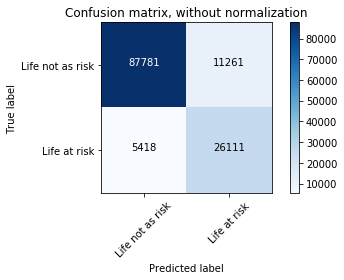

In [8]:
from sklearn.metrics import make_scorer
rfClassifier = RandomForestClassifier(random_state = 300)

rfParameters = {    
  'criterion':['gini', 'entropy'],
  'max_depth':[5, 10],
  'max_features':['auto', 'sqrt', 'log2', None],
  'class_weight': ['balanced', 'balanced_subsample'], 
}

rfClassifier = utils.tuneClassifier(rfClassifier, rfParameters, X_train, X_test, y_train, y_test)

joblib.dump(rfClassifier, 'rfClassifier_reduced.joblib') 


## Tuning AdaBoostClassifier

Unoptimized model
------
F-score on testing data: 0.6646

Optimized Model
------
Final F-score on the testing data: 0.6646


['adaClassifier_reduced.joblib']

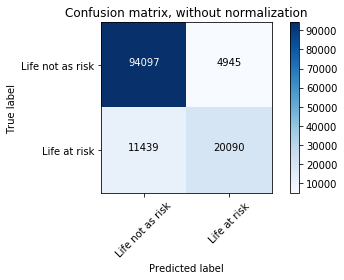

In [9]:

from sklearn.ensemble import AdaBoostClassifier
adaClassifier = AdaBoostClassifier(random_state = 300)

adaParameters = {
  'learning_rate':[0.1, 0.5, 1],
  'algorithm' :['SAMME', 'SAMME.R']
  #'max_features':['auto', 'sqrt', 'log2', None],
}

adaClassifier = utils.tuneClassifier(adaClassifier, adaParameters,  X_train, X_test, y_train, y_test)

joblib.dump(rfClassifier, 'adaClassifier_reduced.joblib') 


# Stacking
## Stacking with to best classifiers

In [10]:
from mlxtend.classifier import StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.metrics import fbeta_score, make_scorer
#meta with Gaussian
sclf = StackingClassifier(classifiers=[rfClassifier, adaClassifier], 
                          use_features_in_secondary = True,
                          meta_classifier=RandomForestClassifier(random_state = 20))
sclf = sclf.fit(X_train, y_train)
sclf_predictions = sclf.predict(X_test)
joblib.dump(sclf, 'sclfb_reduced.joblib') 
print "F-score on StackingClassifier: {:.4f}".format(fbeta_score(y_test, sclf_predictions, beta = 2))

/anaconda2/lib/python2.7/site-packages/mlxtend/classifier/stacking_classification.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X, y)
/anaconda2/lib/python2.7/site-packages/mlxtend/classifier/stacking_classification.py:171: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.meta_clf_.fit(meta_features, y)


F-score on StackingClassifier: 0.7242


## Stacking with all classifiers

In [11]:
from mlxtend.classifier import StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.metrics import fbeta_score, make_scorer
#meta with Gaussian
sclf2 = StackingClassifier(classifiers=[rfClassifier, adaClassifier, GaussianNB()], 
                          use_features_in_secondary = True,
                          meta_classifier=RandomForestClassifier(random_state = 20))
sclf2 = sclf2.fit(X_train, y_train)
sclf_predictions2 = sclf2.predict(X_test)
joblib.dump(sclf2, 'sclf2_reduced.joblib') 
print "F-score on StackingClassifier: {:.4f}".format(fbeta_score(y_test, sclf_predictions2, beta = 2))

F-score on StackingClassifier: 0.7264


In [13]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy = 'not majority')
X_oversampled_train, y_oversampled_train = ros.fit_sample(X_train, y_train)

clfRFC = RandomForestClassifier(random_state = 300)
clfRFC = rfClassifier.fit(X_oversampled_train, y_oversampled_train)
clfRFC_predictions = clfRFC.predict(X_test)
joblib.dump(clfRFC, 'clfRFC_reduced.joblib') 
f_test =  fbeta_score(y_test, clfRFC_predictions, beta = 2)
print("F-score on RandomOverSampler: {:.4f}"%(f_test))

F-score on RandomOverSampler: {:.4f}


In [ ]:
'''
from hpsklearn import HyperoptEstimator, random_forest

estim = HyperoptEstimator( classifier=random_forest('myRFC') )
estim.fit( X_train.values, y_train.values )

predictions_hyper_test = estim.predict(X_test)
f_hyper_test =  recall_score(y_test, predictions_hyper_test)
print("HyperoptEstimator score: %f"%(f_hyper_test))
'''